##### 9 hazard type

In [1]:
import pandas as pd

# loadcleaned RASFF dataset
rasff = pd.read_csv(r"F:\Final_project\rasff_clean1.csv")

In [2]:
rasff.head()

reference                                           category  type  \
0  2025.8491        meat and meat products (other than poultry)  food   
1  2025.8490                                     feed materials  feed   
2  2025.8488  dietetic foods, food supplements and fortified...  food   
3  2025.8487        meat and meat products (other than poultry)  food   
4  2025.8486  dietetic foods, food supplements and fortified...  food   

                                             subject                 date  \
0  Suspected Salmonella i beef and hamburgers fro...  2025-10-31 16:30:35   
1  DNA przeżuwaczy w materiale paszowym dla świń ...  2025-10-31 16:24:06   
2  Food supplements from USA containing prohibite...  2025-10-31 16:01:46   
3  Presence of Listeria monocytogenes ST 451 in d...  2025-10-31 15:55:06   
4  Food supplement with novel food ingredient fro...  2025-10-31 15:48:56   

  notifying_country                          classification   risk_decision  \
0            Sweden  information notification for follow-up  potential risk   
1            Poland  information notification for follow-up  potential risk   
2           Ireland  information notification for attention  potential risk   
3             Italy                      alert notification         serious   
4           Austria  information notification for attention  potential risk   

                                 distribution                    forAttention  \
0                              Denmark,Sweden                             NaN   
1                                         NaN                  Belgium,Poland   
2                                     Ireland           INFOSAN,United States   
3  Austria,Germany,Italy,Netherlands,Slovenia                             NaN   
4                                         NaN  Austria,Ireland,United Kingdom   

                            forFollowUp                    operator  \
0                   Denmark,Netherlands  Denmark,Netherlands,Sweden   
1                               Belgium              Belgium,Poland   
2                         United States               United States   
3  Austria,Germany,Netherlands,Slovenia               Austria,Italy   
4                        United Kingdom      Ireland,United Kingdom   

           origin                  hazards  year  month  
0     Netherlands                      NaN  2025     10  
1         Belgium                      NaN  2025     10  
2   United States                      NaN  2025     10  
3           Italy  Listeria monocytogenes   2025     10  
4  United Kingdom        not in catalogue   2025     10

In [5]:
from openai import OpenAI
from tqdm import tqdm
import time

# 1. Initialize the OpenAI Client
# Ensure your OPENAI_API_KEY is set as an environment variable or passed here
client = OpenAI()

# 2. Define the Target Categories (for validation and reference)
CATEGORIES = [
    "Microbiological", 
    "Chemical/Contaminants", 
    "Mycotoxins", 
    "Allergen", 
    "Physical Contaminants", 
    "Migration from Packaging", 
    "Fraud/Adulteration", 
    "Novel/Unauthorised Ingredient", 
    "Others"
]

# 3. Define the Batch Classification Function
def classify_subject_batch(subject_list, model="gpt-4o-mini", max_retries=3):
    """
    Sends a batch of subjects to the OpenAI API for classification.
    Implements a simple retry mechanism for robustness.
    """
    # Format numbered list for batch
    formatted_subjects = "\n".join([f"{i+1}. {s}" for i, s in enumerate(subject_list)])

    # Insert the formatted subjects into the strong prompt
    prompt = f"""
    You are a specialized food safety expert tasked with classifying RASFF alert subject lines. Your goal is to identify the single, most critical **TECHNICAL HAZARD TYPE** present in the food or feed product.

    **STRICT RULES FOR CLASSIFICATION:**
    1.  **Technical Hazard Priority:** Always classify by the **type of contaminant/agent** (e.g., bacteria, metal, pesticide) over the **regulatory status** (e.g., 'unauthorized', 'absence of certificate').
    2.  **Language Handling:** If the subject line contains multiple languages (separated by // or ///), use the English text for classification.
    3.  **Output Format:** Return the category as a numbered list, with ONLY the category name on each line. Do not include quotes, numbering, or any other text.
    4.  **Novel/Unauthorised:** Use this category ONLY for substances that are unauthorized or not approved for the specific food use.
    5.  **OTHERS:** Use this ONLY when the subject describes a purely administrative or procedural issue with no mention of a physical, chemical, or biological contaminant.

    **TECHNICAL HAZARD CATEGORIES & DEFINITIONS:**

    1.  **Microbiological:** Harmful living organisms like bacteria, viruses, parasites, or fungi. (Focus on names like *Salmonella*, *Listeria*, *E. coli*).
    2.  **Chemical/Contaminants:** Specific non-mycotoxin chemicals, heavy metals, industrial contaminants, pesticide residues, or unauthorized additives. (Focus on substances like *titanium dioxide*, *lead*, *oxamyl*, *dioxins*).
    3.  **Mycotoxins:** Toxins produced by molds/fungi, primarily found in grains, nuts, and dried fruit. (Focus on names like *Aflatoxin*, *Ochratoxin*).
    4.  **Allergen:** Undeclared ingredients that cause allergic reactions. (Focus on *undeclared*, *milk*, *soy*, *peanut*, *CASEINE*).
    5.  **Physical Contaminants:** Foreign objects causing physical harm or injury. (Focus on *glass*, *metal*, *plastic*, *stone*, *bone*).
    6.  **Migration from Packaging:** Chemical substances transferring from the packaging into the food/feed. (Focus on *migration*, *PAA*, *Bisphenol*).
    7.  **Fraud/Adulteration:** Intentional deception regarding a product's composition or identity, typically for economic gain. (Focus on *adulterated*, *mismatch*, *mislabelled origin*).
    8.  **Novel/Unauthorised Ingredient:** Ingredients that have not been authorized under novel food regulations. (Focus on *novel food ingredient*, *unauthorized botanicals*).
    9.  **Others:** No technical hazard is specified (e.g., only 'Absence of official certificates').

    **CLASSIFY THE FOLLOWING SUBJECT LINES:**

    Now classify the following subjects:

    Subject:
    "{formatted_subjects}"

    Return the output as a numbered list with ONLY the category name per line, e.g.:
    1. Microbiological
    2. Chemical/Contaminants
    3. Others
    """
    
    # Simple retry logic
    for attempt in range(max_retries):
        try:
            response = client.chat.completions.create(
                model=model,
                messages=[{"role": "user", "content": prompt}],
                temperature=0, # Use 0 for deterministic classification tasks
            )

            # Process the response: extract and validate categories
            raw_output = response.choices[0].message.content.strip().split("\n")
            cleaned_output = []
            
            for line in raw_output:
                # Remove the number and period (e.g., "1. Microbiological" -> "Microbiological")
                if ". " in line:
                    cat = line.split(". ", 1)[1].strip()
                else:
                    cat = line.strip()
                
                # Validation: Fallback to "Others" if the LLM hallucinated a category name
                if cat not in CATEGORIES:
                    cat = "Others"
                
                # Stop when the number of classified items matches the input
                if len(cleaned_output) < len(subject_list):
                    cleaned_output.append(cat)
            
            # Pad with "Others" if the LLM output was too short (rare but possible)
            while len(cleaned_output) < len(subject_list):
                 cleaned_output.append("Others")

            return cleaned_output

        except Exception as e:
            print(f"API Error on attempt {attempt + 1}/{max_retries}: {e}")
            if attempt < max_retries - 1:
                # Wait for 2^attempt seconds before retrying (Exponential Backoff)
                time.sleep(2 ** attempt)
            else:
                print(f"Failed to classify batch after {max_retries} attempts. Returning 'Others' for batch.")
                return ["Others"] * len(subject_list)
    return ["Others"] * len(subject_list) # Should not be reached

# 4. Main Execution Block for DataFrame
def classify_full_dataframe(df, subject_column='subject', batch_size=50):
    """Classifies the entire DataFrame in batches."""
    
    # ⚠️ IMPORTANT: Handle potential missing values by converting to string
    subjects = df[subject_column].fillna("N/A - Missing Subject").astype(str).tolist()
    
    results = []
    
    # Use tqdm for a professional progress bar
    for i in tqdm(range(0, len(subjects), batch_size), desc="Classifying RASFF Subjects"):
        batch = subjects[i:i + batch_size]
        batch_results = classify_subject_batch(batch)
        results.extend(batch_results)
        
        # Add a short delay to respect rate limits
        time.sleep(0.1) 
        
    df['Hazard_Type'] = results
    return df



In [6]:
#how to run this on your DataFrame (assuming it's loaded as 'rasff')
rasff_new = classify_full_dataframe(rasff)
print(rasff_new['Hazard_Type'].value_counts())

Classifying RASFF Subjects:   0%|          | 0/548 [00:00<?, ?it/s]

Classifying RASFF Subjects: 100%|██████████| 548/548 [53:07<00:00,  5.82s/it]

Hazard_Type
Chemical/Contaminants            8741
Microbiological                  6758
Mycotoxins                       3210
Others                           2968
Novel/Unauthorised Ingredient    2842
Allergen                         1238
Physical Contaminants            1024
Migration from Packaging          557
Fraud/Adulteration                 59
Name: count, dtype: int64


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_17736\2614980979.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_hazards.values, y=top_hazards.index, palette='Spectral')


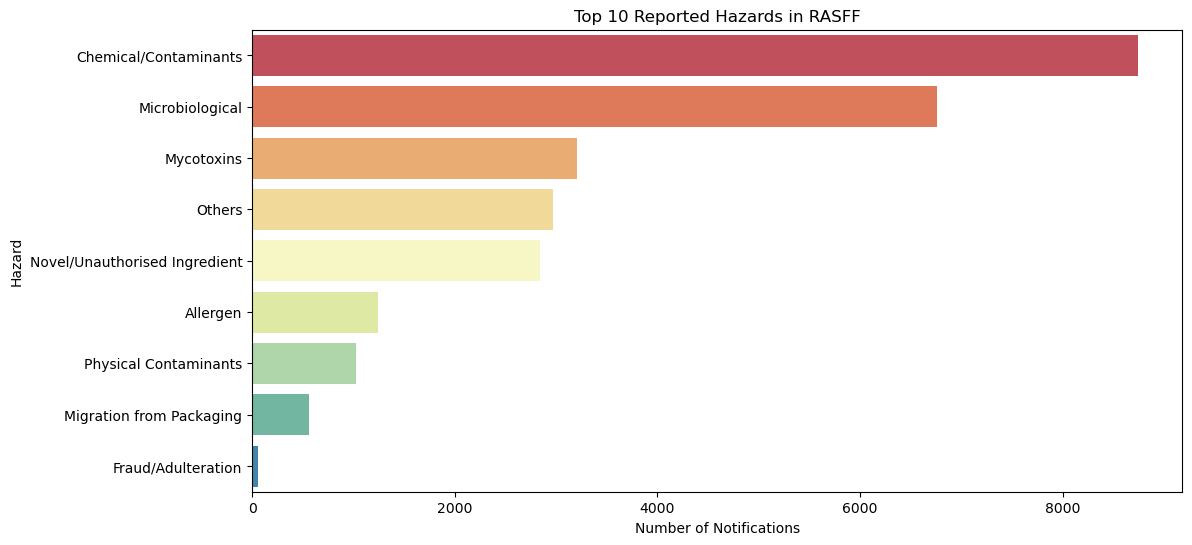

In [8]:
top_hazards = rasff['Hazard_Type'].value_counts()
plt.figure(figsize=(12,6))
sns.barplot(x=top_hazards.values, y=top_hazards.index, palette='Spectral')
plt.title("Top 10 Reported Hazards in RASFF")
plt.xlabel("Number of Notifications")
plt.ylabel("Hazard")
plt.show()

In [9]:
rasff.to_csv("rasff_new1.csv", index=False)



##### Now binary classification to create 'Regulatory_Issue_Flag'

In [13]:
import pandas as pd
import re
from typing import List

# Define the Rule-Based Classification Function (Fast and Efficient)

def add_regulatory_flag(
    df: pd.DataFrame, 
    subject_column: str = 'Subject', 
    new_column_name: str = 'Regulatory_Issue_Flag'
) -> pd.DataFrame:
    """
    Creates a binary flag (1 or 0) for regulatory/administrative issues 
    based on keywords in the subject line. This is a fast, vectorized, 
    and rule-based method designed to complement the LLM classification.

    Args:
        df (pd.DataFrame): The input DataFrame.
        subject_column (str): The name of the column containing the subject lines.
        new_column_name (str): The name of the new binary flag column to create.

    Returns:
        pd.DataFrame: The DataFrame with the added 'Regulatory_Issue_Flag' column.
    """
    
    # --------------------------------------------------------------------------
    # CORRECTED Rule Definition: More robust keywords and synonyms/plurals.
    # --------------------------------------------------------------------------
    regulatory_keywords: List[str] = [
        # Compliance/Non-Compliance
        r'\bcompliance\b', r'\bcompliant\b', r'\bnon-compliant\b', r'\bnoncompliant\b',
        # Authorization/Approval
        r'\bunauthorized\b', r'\bunauthorised\b', r'\bunapproved\b', r'\bprohibited\b',
        # Certificates/Documentation
        r'\bcertificate(?:s)?\b', r'\bcertification\b', r'\bmissing document\b',
        r'\bofficial certificate(?:s)?\b',
        # Labeling/Allergens
        r'\blabeling\b', r'\bincorrect label\b', r'\bmislabeled\b', r'\bmislabelled\b',
        r'\bundeclared\b', r'\bmisslabeled\b',
        # Residue Limits
        r'\bMRL\b', r'\bmaximum residue limit\b', r'\blimit exceed(?:ed|ance)\b',
        # Actions/Legal Status
        r'\btraceability\b', r'\brecall\b', r'\bwithdrawn\b', r'\bsuspension\b',
        r'\blegal\b', r'\bregulation(?:s)?\b', r'\bexport ban\b', r'\breject\b',
        # Fraud/Deception
        r'\bfraud\b', r'\badulterat(?:ion|ed)\b', r'\bmismatch\b'
    ]
    
    # Join keywords into a single RegEx pattern using OR operator (|)
    regex_pattern: str = '|'.join(regulatory_keywords)
    
    print(f"Applying rule-based regulatory classification...")

    # Vectorized Operation: This step is extremely fast (efficient)
    df[new_column_name] = (
        df[subject_column]
        .astype(str)
        .str.lower()
        # Case=False is redundant here since we lowercased, but kept for clarity
        .str.contains(regex_pattern, case=False, na=False, regex=True) 
        .astype(int)
    )
    
    print(f"Rule-based flagging complete. {df[new_column_name].sum()} incidents flagged as potential regulatory issues.")
    return df


# --- Example Usage (Using the corrected 'Subject' column name for consistency) ---

if __name__ == '__main__':
    
    # --- Mock Data Setup (Simulating the output after your LLM classification) ---
    # NOTE: The subject column name has been explicitly corrected to 'Subject' 
    # to match the mock data key and the likely real column name.
    mock_data = {
        'Subject': [
            "Salmonella in frozen poultry from Brazil.",                # 0 (Only Microbial)
            "Unauthorised additive E250 in spice mix.",                 # 1 (Unauthorized/Unauthorised)
            "Glass fragment found in imported cereal.",                 # 0 (Only Physical)
            "Absence of official certificates for sea bass.",           # 1 (official certificates)
            "Undeclared milk allergen in chocolate.",                   # 1 (Undeclared)
            "Aflatoxin B1 contamination in peanuts.",                   # 0 (Only Mycotoxin)
            "MRL exceedance of Cadmium in shellfish.",                  # 1 (MRL/exceedance)
            "Incorrect labeling of country of origin (Fraud).",         # 1 (Labeling/Fraud)
            "Migration of primary aromatic amines from packaging.",     # 0 (This is a technical issue, not a regulatory word)
            "Contamination with Listeria Monocytogenes (no fraud)."     # 1 (Contains 'fraud', even if negated)
        ],
        'Hazard_Type': [
            "Microbiological", 
            "Chemical/Contaminants", 
            "Physical Contaminants", 
            "Others", 
            "Allergen", 
            "Mycotoxins", 
            "Chemical/Contaminants", 
            "Fraud/Adulteration", 
            "Migration from Packaging", 
            "Microbiological"
        ]
    }
    rasff_df = pd.DataFrame(mock_data)

    print("--- Starting Regulatory Flagging on Mock Data ---")
    
    # Call the function on the DataFrame, explicitly using 'Subject' as the column name
    rasff_df_flagged = add_regulatory_flag(rasff_df, subject_column='Subject')

    print("\n--- Final Classified & Flagged Data ---")
    print(rasff_df_flagged.to_markdown(index=False))

    print(f"\nTotal Regulatory Flags: {rasff_df_flagged['Regulatory_Issue_Flag'].sum()}")

--- Starting Regulatory Flagging on Mock Data ---
Applying rule-based regulatory classification...
Rule-based flagging complete. 6 incidents flagged as potential regulatory issues.

--- Final Classified & Flagged Data ---
| Subject                                               | Hazard_Type              |   Regulatory_Issue_Flag |
|:------------------------------------------------------|:-------------------------|------------------------:|
| Salmonella in frozen poultry from Brazil.             | Microbiological          |                       0 |
| Unauthorised additive E250 in spice mix.              | Chemical/Contaminants    |                       1 |
| Glass fragment found in imported cereal.              | Physical Contaminants    |                       0 |
| Absence of official certificates for sea bass.        | Others                   |                       1 |
| Undeclared milk allergen in chocolate.                | Allergen                 |                       1 |
|

In [14]:
rasff_flag=add_regulatory_flag(rasff, subject_column='subject')

Applying rule-based regulatory classification...
Rule-based flagging complete. 4662 incidents flagged as potential regulatory issues.


In [16]:
print(f"\nTotal Regulatory Flags: {rasff_flag['Regulatory_Issue_Flag'].sum()}")


Total Regulatory Flags: 4662


In [17]:
rasff_flag['Regulatory_Issue_Flag']

0        0
1        0
2        1
3        0
4        0
        ..
27392    0
27393    0
27394    0
27395    0
27396    0
Name: Regulatory_Issue_Flag, Length: 27397, dtype: int64

In [19]:
rasff_flag.to_csv("rasff_new2.csv", index=False)

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Visualization Function ---

def generate_analysis_plots(df: pd.DataFrame):
    """
    Generates three key visualizations to analyze the classified RASFF data.

    Args:
        df (pd.DataFrame): The DataFrame containing 'Hazard_Type' and 'Regulatory_Issue_Flag'.
    """
    
    # 1. Ensure the classification columns exist and are correctly typed
    if 'Hazard_Type' not in df.columns or 'Regulatory_Issue_Flag' not in df.columns:
        print("Error: DataFrame must contain 'Hazard_Type' (LLM) and 'Regulatory_Issue_Flag' (Rule) columns.")
        return
    
    df['Regulatory_Issue_Flag'] = df['Regulatory_Issue_Flag'].astype(int)
    
    # Set the style for better visual aesthetics
    sns.set_theme(style="whitegrid")
    
    # Create the figure and axes for the plots
    fig, axes = plt.subplots(3, 1, figsize=(14, 18))
    plt.subplots_adjust(hspace=0.45)

    
    # =========================================================================
    # PLOT 1: Overall Hazard Type Distribution (Count Plot)
    # =========================================================================
    
    print("Generating Plot 1: Hazard Type Distribution...")
    order = df['Hazard_Type'].value_counts().index
    sns.countplot(
        y='Hazard_Type', 
        data=df, 
        order=order, 
        palette="viridis", 
        ax=axes[0]
    )
    axes[0].set_title('1. Total Number of Incidents by Primary Technical Hazard Type', fontsize=16)
    axes[0].set_xlabel('Number of Incidents')
    axes[0].set_ylabel('Hazard Type')
    
    # Add data labels
    for i, count in enumerate(df['Hazard_Type'].value_counts(ascending=False)):
        axes[0].text(count + 50, i, str(count), va='center')


    # =========================================================================
    # PLOT 2: Regulatory Flag Rate by Hazard Type (Bar Plot)
    # This shows the percentage of each hazard type that is explicitly regulatory.
    # =========================================================================
    
    print("Generating Plot 2: Regulatory Flag Rate by Hazard Type...")
    
    # Calculate the mean of the flag (which is the rate/percentage) for each hazard type
    regulatory_rate = df.groupby('Hazard_Type')['Regulatory_Issue_Flag'].mean().sort_values(ascending=False) * 100
    
    sns.barplot(
        x=regulatory_rate.values, 
        y=regulatory_rate.index, 
        palette="rocket", 
        ax=axes[1]
    )
    axes[1].set_title('2. Regulatory Issue Rate (%) within Each Hazard Type', fontsize=16)
    axes[1].set_xlabel('Percentage of Incidents Flagged as Regulatory (%)')
    axes[1].set_ylabel('Hazard Type')
    axes[1].set_xlim(0, 105) 
    
    # Add data labels
    for i, rate in enumerate(regulatory_rate.values):
        axes[1].text(rate + 2, i, f'{rate:.1f}%', va='center')


    # =========================================================================
    # PLOT 3: Stacked Bar Plot: Hazard Type Broken Down by Regulatory Flag
    # =========================================================================

    print("Generating Plot 3: Stacked Breakdown...")
    
    # Create a contingency table (cross-tabulation)
    pivot_df = df.groupby('Hazard_Type')['Regulatory_Issue_Flag'].value_counts().unstack(fill_value=0)
    
    # Calculate percentages for stacking
    pivot_df_perc = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100
    
    # Plot the stacked bar chart (using Flag 0 and Flag 1)
    pivot_df_perc.plot(
        kind='barh', 
        stacked=True, 
        color=['#4C72B0', '#DC4400'], # Blue for No Flag (0), Red for Flag (1)
        ax=axes[2]
    )
    axes[2].set_title('3. Hazard Type Breakdown: Regulatory vs. Purely Technical', fontsize=16)
    axes[2].set_xlabel('Proportion of Incidents (%)')
    axes[2].set_ylabel('Hazard Type')
    axes[2].legend(title='Regulatory Issue Flag', labels=['No Flag (0)', 'Flagged (1)'], loc='lower right')
    
    # Improve x-axis labeling for percentages
    axes[2].set_xticks(np.arange(0, 101, 10))
    axes[2].tick_params(axis='x', rotation=0)

    plt.suptitle('RASFF Data Analysis: Technical Hazard vs. Regulatory Issue', fontsize=20, fontweight='bold')
    plt.show()
    print("All plots successfully generated.")


Generating Plot 1: Hazard Type Distribution...
Generating Plot 2: Regulatory Flag Rate by Hazard Type...
Generating Plot 3: Stacked Breakdown...


C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_17736\1229382090.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(
C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_17736\1229382090.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


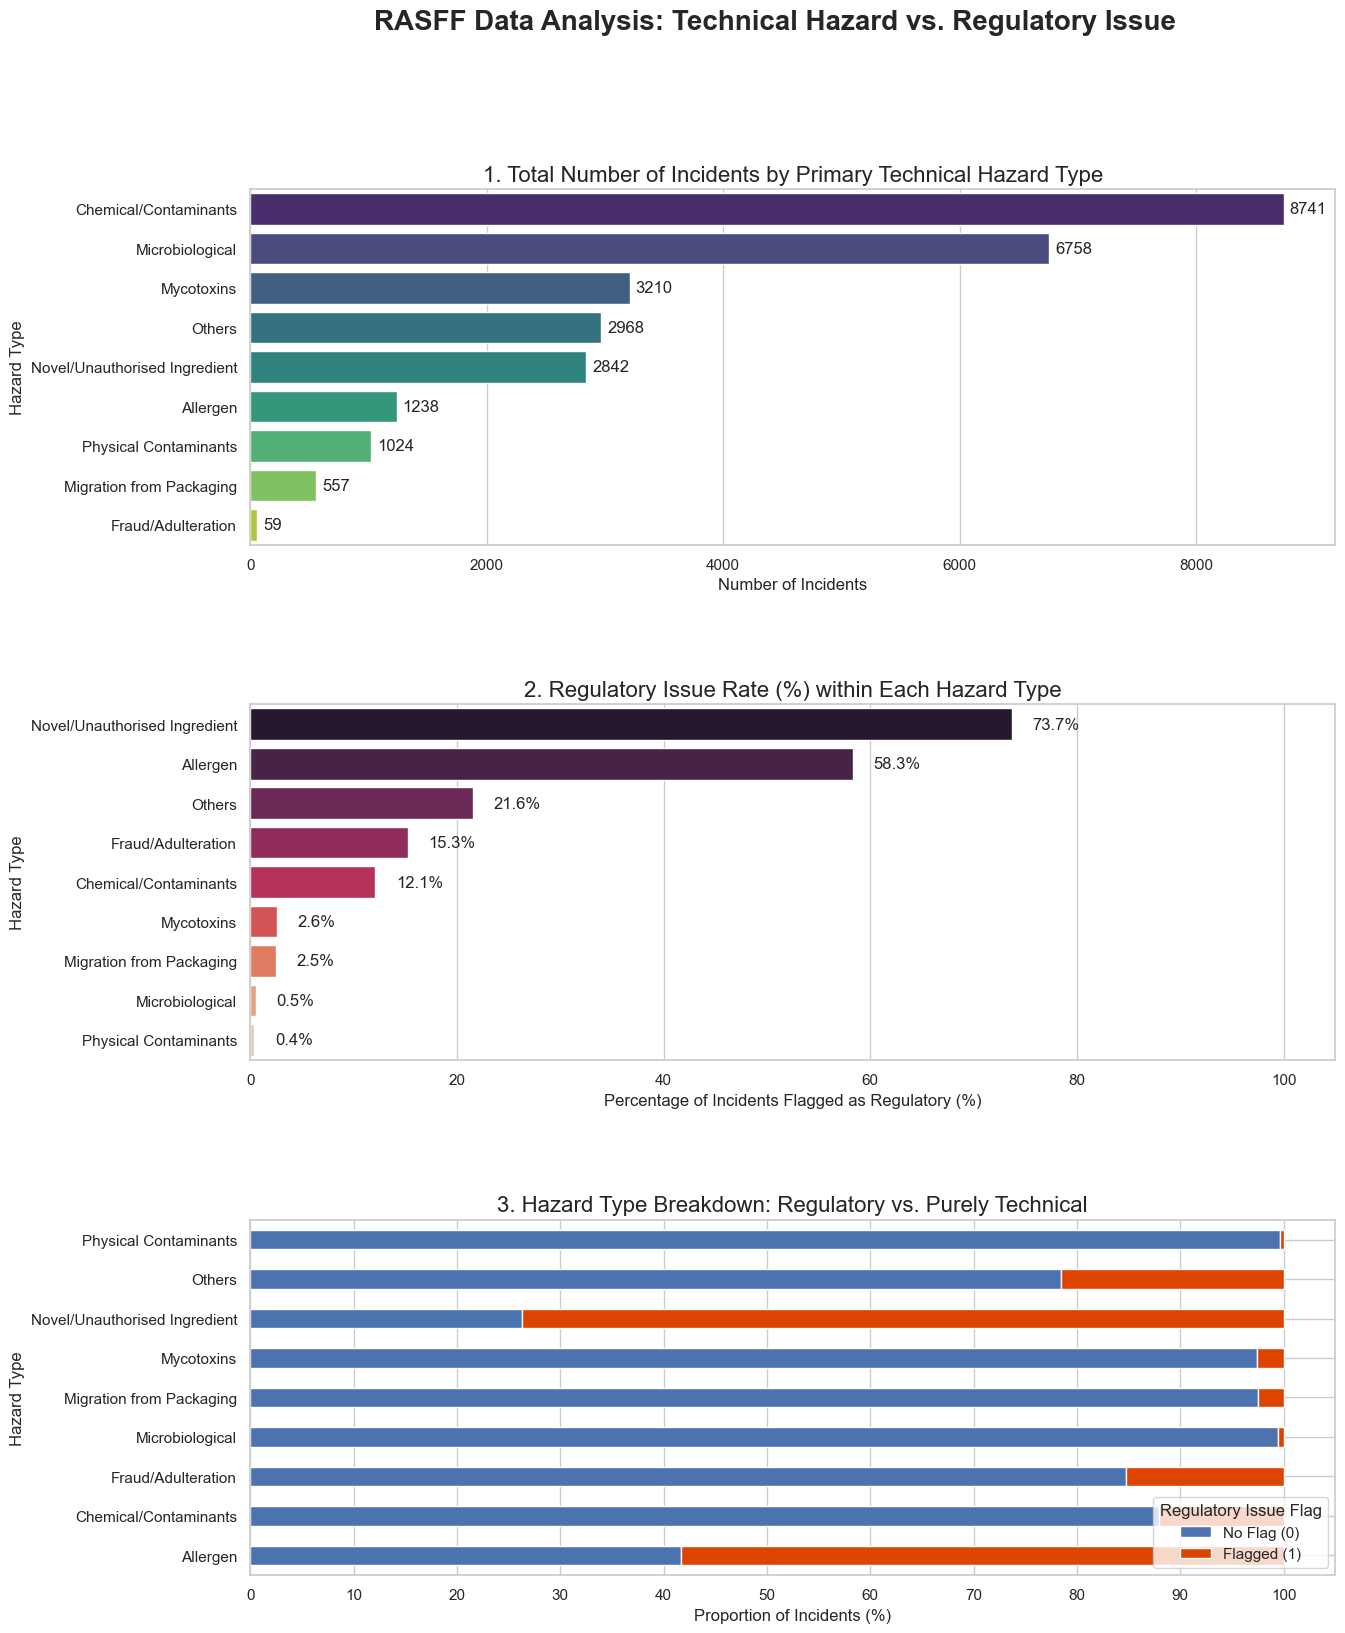

All plots successfully generated.


In [21]:
generate_analysis_plots(rasff_flag)

In [71]:
rasff_flag=pd.read_csv(r"F:\Final_project\rasff_new2.csv")

In [72]:
rasff_flag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27397 entries, 0 to 27396
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   reference              27397 non-null  float64
 1   category               27397 non-null  object 
 2   type                   27397 non-null  object 
 3   subject                27397 non-null  object 
 4   date                   27397 non-null  object 
 5   notifying_country      27397 non-null  object 
 6   classification         27397 non-null  object 
 7   risk_decision          27397 non-null  object 
 8   distribution           18759 non-null  object 
 9   forAttention           14966 non-null  object 
 10  forFollowUp            13810 non-null  object 
 11  operator               27303 non-null  object 
 12  origin                 26823 non-null  object 
 13  hazards                20241 non-null  object 
 14  year                   27397 non-null  int64  
 15  mo

In [73]:
rasff_flag['category'].value_counts()

category
fruits and vegetables                                   4934
nuts, nut products and seeds                            3291
poultry meat and poultry meat products                  2309
dietetic foods, food supplements and fortified foods    1947
cereals and bakery products                             1779
herbs and spices                                        1763
fish and fish products                                  1476
meat and meat products (other than poultry)             1155
food contact materials                                  1114
feed materials                                          1072
other food product / mixed                              1068
milk and milk products                                   655
prepared dishes and snacks                               633
confectionery                                            633
bivalve molluscs and products thereof                    541
cocoa and cocoa preparations, coffee and tea             512
crustaceans and

In [28]:
rasff_flag['type'].value_counts()

type
food                                        24696
feed                                         1566
food contact material                        1106
other                                          15
animals                                        10
plants, plant products and other objects        4
Name: count, dtype: int64

In [30]:
rasff_flag['classification'].value_counts()

classification
border rejection notification             8420
alert notification                        7995
information notification for attention    6287
information notification for follow-up    4692
non-compliance notification                  3
Name: count, dtype: int64

In [31]:
rasff_flag['risk_decision'].value_counts()

risk_decision
serious                14756
not serious             4134
undecided               3029
potential risk          2689
potentially serious     2372
no risk                  417
Name: count, dtype: int64

In [32]:
rasff_flag['origin'].value_counts()

origin
Türkiye                        2594
Poland                         1760
India                          1720
China                          1660
Netherlands                    1365
                               ... 
Germany,Hungary,Malaysia          1
Austria,Switzerland               1
Bulgaria,Germany,India            1
India,unknown origin              1
Belgium,Germany,Netherlands       1
Name: count, Length: 609, dtype: int64

##### Lagged risk score

In [33]:
import pandas as pd
from datetime import timedelta

def create_lagged_risk_score(df: pd.DataFrame, entity_column: str = 'category', lookback_days: int = 365) -> pd.DataFrame:
    """
    Calculates a time-dependent, lagged risk score (alert count) for a specified entity 
    (e.g., Product Category or Country of Origin) by counting its incidents in the 
    preceding time window. This feature is crucial for proactive prediction as it 
    prevents data leakage.

    Args:
        df (pd.DataFrame): The input DataFrame.
        entity_column (str): The column representing the entity to track (default is 'category').
        lookback_days (int): The window size in days for counting historical alerts.

    Returns:
        pd.DataFrame: The DataFrame with the new lagged risk score column.
    """
    
    # 1. Ensure 'date' is in datetime format and sort the data chronologically
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(by='date').reset_index(drop=True)
    
    # 2. Clean up the entity column: focuses on the first entity if multiple are listed.
    # This ensures consistency for tracking (e.g., 'origin': 'Country A, Country B' -> 'Country A')
    clean_column_name = f'clean_{entity_column}'
    df[clean_column_name] = df[entity_column].astype(str).str.split(',').str[0].str.strip()

    # 3. Initialize the risk score column
    new_column_name = f'{entity_column}_Alerts_Last_{lookback_days}d'
    df[new_column_name] = 0

    print(f"Calculating time-dependent risk score for '{entity_column}': {new_column_name}...")

    # Group by the cleaned entity for efficient processing
    grouped = df.groupby(clean_column_name)

    # Iterate through each group (category, country, etc.) and calculate the lagged score
    for name, group in grouped:
        
        lagged_counts = []
        
        # Iterate over each row (incident) chronologically
        for i in range(len(group)):
            current_date = group.iloc[i]['date']
            
            # Define the start date of the look-back window
            start_date = current_date - timedelta(days=lookback_days)
            
            # Count incidents for this entity that occurred *before* the current incident date
            past_incidents = group.iloc[:i]
            
            count = past_incidents[
                (past_incidents['date'] >= start_date) & 
                (past_incidents['date'] < current_date)
            ].shape[0]
            
            lagged_counts.append(count)

        # Assign the calculated counts back to the original DataFrame indices
        df.loc[group.index, new_column_name] = lagged_counts
        
    print(f"Calculation complete. New feature '{new_column_name}' created.")
    return df.drop(columns=[clean_column_name])


# --- Example Usage (How you would run this function) ---
if __name__ == '__main__':
    # Mock data to demonstrate Category-based Lagged Risk
    data = {
        'date': ['2023-01-01', '2023-03-01', '2023-07-01', '2024-01-01', '2024-02-01', '2024-03-01'],
        'origin': ['Türkiye', 'China', 'Türkiye', 'China', 'Türkiye', 'Türkiye'],
        'category': ['Nuts', 'Spices', 'Nuts', 'Spices', 'Nuts', 'Nuts'],
        'subject': ['Aflatoxin', 'Pesticide', 'Salmonella', 'Listeria', 'Undeclared Milk', 'Fraud']
    }
    mock_df = pd.DataFrame(data)
    
    # 1. Calculate Category Risk (The Primary Feature)
    df_with_risk_category = create_lagged_risk_score(mock_df.copy(), entity_column='category', lookback_days=180)
    
    # 2. Calculate Origin Risk (The Secondary Feature)
    df_with_all_risk = create_lagged_risk_score(df_with_risk_category.copy(), entity_column='origin', lookback_days=365)
    
    print("\n--- Final Data with Category (180d) and Origin (365d) Risk Scores ---")
    print(df_with_all_risk[['date', 'category', 'origin', 'category_Alerts_Last_180d', 'origin_Alerts_Last_365d']].to_markdown(index=False))

Calculating time-dependent risk score for 'category': category_Alerts_Last_180d...
Calculation complete. New feature 'category_Alerts_Last_180d' created.
Calculating time-dependent risk score for 'origin': origin_Alerts_Last_365d...
Calculation complete. New feature 'origin_Alerts_Last_365d' created.

--- Final Data with Category (180d) and Origin (365d) Risk Scores ---
| date                | category   | origin   |   category_Alerts_Last_180d |   origin_Alerts_Last_365d |
|:--------------------|:-----------|:---------|----------------------------:|--------------------------:|
| 2023-01-01 00:00:00 | Nuts       | Türkiye  |                           0 |                         0 |
| 2023-03-01 00:00:00 | Spices     | China    |                           0 |                         0 |
| 2023-07-01 00:00:00 | Nuts       | Türkiye  |                           0 |                         1 |
| 2024-01-01 00:00:00 | Spices     | China    |                           0 |                    

In [34]:
# 1. Calculate Category Risk (The Primary Feature)
df1 = create_lagged_risk_score(rasff_flag.copy(), entity_column='category', lookback_days=180)

Calculating time-dependent risk score for 'category': category_Alerts_Last_180d...
Calculation complete. New feature 'category_Alerts_Last_180d' created.


In [35]:
# 2. Calculate Origin Risk (The Secondary Feature)
df2 = create_lagged_risk_score(df1.copy(), entity_column='origin', lookback_days=365)

Calculating time-dependent risk score for 'origin': origin_Alerts_Last_365d...
Calculation complete. New feature 'origin_Alerts_Last_365d' created.


In [36]:
print("\n--- Final Data with Category (180d) and Origin (365d) Risk Scores ---")
print(df2[['date', 'category', 'origin', 'category_Alerts_Last_180d', 'origin_Alerts_Last_365d']].to_markdown(index=False))


--- Final Data with Category (180d) and Origin (365d) Risk Scores ---
| date                | category                                             | origin                                                                                                         |   category_Alerts_Last_180d |   origin_Alerts_Last_365d |
|:--------------------|:-----------------------------------------------------|:---------------------------------------------------------------------------------------------------------------|----------------------------:|--------------------------:|
| 2020-01-02 09:24:48 | fruits and vegetables                                | Türkiye                                                                                                        |                           0 |                         0 |
| 2020-01-02 11:06:54 | fruits and vegetables                                | Türkiye                                                                                             

In [42]:
rasff_flag=pd.read_csv(r"F:\Final_project\rasff_new2.csv")

In [43]:
rasff_flag.head()

reference                                           category  type  \
0  2025.8491        meat and meat products (other than poultry)  food   
1  2025.8490                                     feed materials  feed   
2  2025.8488  dietetic foods, food supplements and fortified...  food   
3  2025.8487        meat and meat products (other than poultry)  food   
4  2025.8486  dietetic foods, food supplements and fortified...  food   

                                             subject                 date  \
0  Suspected Salmonella i beef and hamburgers fro...  2025-10-31 16:30:35   
1  DNA przeżuwaczy w materiale paszowym dla świń ...  2025-10-31 16:24:06   
2  Food supplements from USA containing prohibite...  2025-10-31 16:01:46   
3  Presence of Listeria monocytogenes ST 451 in d...  2025-10-31 15:55:06   
4  Food supplement with novel food ingredient fro...  2025-10-31 15:48:56   

  notifying_country                          classification   risk_decision  \
0            Sweden  information notification for follow-up  potential risk   
1            Poland  information notification for follow-up  potential risk   
2           Ireland  information notification for attention  potential risk   
3             Italy                      alert notification         serious   
4           Austria  information notification for attention  potential risk   

                                 distribution                    forAttention  \
0                              Denmark,Sweden                             NaN   
1                                         NaN                  Belgium,Poland   
2                                     Ireland           INFOSAN,United States   
3  Austria,Germany,Italy,Netherlands,Slovenia                             NaN   
4                                         NaN  Austria,Ireland,United Kingdom   

                            forFollowUp                    operator  \
0                   Denmark,Netherlands  Denmark,Netherlands,Sweden   
1                               Belgium              Belgium,Poland   
2                         United States               United States   
3  Austria,Germany,Netherlands,Slovenia               Austria,Italy   
4                        United Kingdom      Ireland,United Kingdom   

           origin                  hazards  year  month  \
0     Netherlands                      NaN  2025     10   
1         Belgium                      NaN  2025     10   
2   United States                      NaN  2025     10   
3           Italy  Listeria monocytogenes   2025     10   
4  United Kingdom        not in catalogue   2025     10   

                     Hazard_Type  Regulatory_Issue_Flag  
0                Microbiological                      0  
1                         Others                      0  
2          Chemical/Contaminants                      1  
3                Microbiological                      0  
4  Novel/Unauthorised Ingredient                      0

In [45]:
import pandas as pd
from datetime import timedelta
from sklearn.preprocessing import LabelEncoder

# --- Feature Engineering Function (Lagged Risk Score) ---

def create_lagged_risk_score(df: pd.DataFrame, entity_column: str, lookback_days: int) -> pd.DataFrame:
    """
    Calculates a time-dependent, lagged risk score (alert count) for a specified entity 
    by counting its incidents in the preceding time window, preventing data leakage.
    """
    
    # Ensure 'date' is datetime and data is sorted
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df = df.dropna(subset=['date']).sort_values(by='date').reset_index(drop=True)
    
    # Handle NaN values in the entity column gracefully: 
    # This step is mainly defensive now, as we drop NaNs in the main block, 
    # but ensures no crashes if called directly with NaNs.
    df[entity_column] = df[entity_column].fillna('MISSING')
    
    # Use a clean version of the entity column for grouping/lagging
    clean_column_name = f'clean_{entity_column}'
    # Clean the origin string (focus on the first country listed)
    df[clean_column_name] = df[entity_column].astype(str).str.split(',').str[0].str.strip()
    
    new_column_name = f'{entity_column}_Alerts_Last_{lookback_days}d'
    df[new_column_name] = 0

    print(f"Calculating time-dependent risk score for '{entity_column}' ({lookback_days} days)...")
    grouped = df.groupby(clean_column_name)

    # Calculate the lagged count iteratively (optimized for grouped data)
    for name, group in grouped:
        lagged_counts = []
        for i in range(len(group)):
            current_date = group.iloc[i]['date']
            start_date = current_date - timedelta(days=lookback_days)
            
            # Use data strictly BEFORE the current incident (iloc[:i])
            past_incidents = group.iloc[:i]
            
            count = past_incidents[
                (past_incidents['date'] >= start_date) & 
                (past_incidents['date'] < current_date)
            ].shape[0]
            
            lagged_counts.append(count)

        df.loc[group.index, new_column_name] = lagged_counts
        
    print(f"Feature '{new_column_name}' created.")
    return df.drop(columns=[clean_column_name])


def prepare_data_for_modeling(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.Series, LabelEncoder]:
    """
    Prepares the final feature matrix (X) and target vector (y) for modeling.
    Assumes necessary NaNs have already been dropped.
    """
    
    # 1. Feature Selection
    FEATURE_COLS = [
        'category', 'origin', 'notifying_country', 
        'year', 'month', 'Hazard_Type', 
        'Regulatory_Issue_Flag', 'classification',
        'category_Alerts_Last_180d', 'origin_Alerts_Last_365d'
    ]
    
    # 2. Target Variable (y) Encoding
    # Define a clear risk hierarchy for ordinal encoding (Critical for multi-class)
    RISK_ORDER = ['no risk', 'undecided', 'potential risk', 'potentially serious', 'not serious', 'serious']
    
    # Convert 'risk_decision' to ordered categories
    df['risk_decision'] = pd.Categorical(
        df['risk_decision'], 
        categories=RISK_ORDER, 
        ordered=True
    )
    
    # Use LabelEncoder to convert the ordered categories to numerical targets (0 to 5)
    # This is required for XGBoost multi-class training.
    risk_encoder = LabelEncoder()
    df['risk_target'] = risk_encoder.fit_transform(df['risk_decision'])
    y = df['risk_target']

    print(f"\nTarget Variable 'risk_decision' mapped to numerical labels (0 to {len(RISK_ORDER) - 1}):")
    for i, label in enumerate(RISK_ORDER):
        print(f"  {i}: {label}")


    # 3. Feature Engineering & Preparation
    # a. Temporal Features (month and year are already discrete integers)
    df['month'] = df['month'].astype(int)
    df['year'] = df['year'].astype(int)

    # b. Categorical Features
    categorical_cols = ['category', 'origin', 'notifying_country', 'Hazard_Type', 'classification']
    
    # Use Pandas Categorical dtype for efficient XGBoost handling of sparse categories
    for col in categorical_cols:
        df[col] = df[col].astype('category')
        
    # Final feature matrix X
    X = df[FEATURE_COLS]
    
    return X, y, risk_encoder

# --- Main Execution Block ---

if __name__ == '__main__':
    # =========================================================================
    # STEP 0: LOAD YOUR DATA HERE
    # Replace the line below with the code to load your actual rasff_flag dataset
    # Example: rasff_flag = pd.read_csv('your_rasff_data.csv')
    # Make sure your DataFrame is named 'rasff_flag'
    
    # Since I cannot load your file, I am using an empty DataFrame as a placeholder
    # which will require you to replace this block:
    rasff_flag=pd.read_csv(r"F:\Final_project\rasff_new2.csv")
    # =========================================================================
    
    if rasff_flag.empty:
        print("ERROR: Please replace the placeholder above with your data loading code.")
    else:
        print("--- Starting Feature Engineering Pipeline ---")

        # B. CRUCIAL STEP: Drop rows with missing values in key prediction features early.
        initial_rows = len(rasff_flag)
        # We assume 'category' and 'notifying_country' also need to be non-null for modeling
        rasff_flag.dropna(subset=['origin', 'category', 'notifying_country', 'date'], inplace=True)
        rows_after_drop = len(rasff_flag)
        
        print(f"Dropped {initial_rows - rows_after_drop} rows due to missing critical features.")
        
        # C. Calculate Lagged Risk Scores
        # 1. Category Risk (180 days lookback)
        rasff_flag_lagged = create_lagged_risk_score(rasff_flag, entity_column='category', lookback_days=180)
        
        # 2. Origin Risk (365 days lookback)
        rasff_flag_lagged = create_lagged_risk_score(rasff_flag_lagged, entity_column='origin', lookback_days=365)
        
        # D. Prepare final X and y
        X, y, risk_encoder = prepare_data_for_modeling(rasff_flag_lagged.copy())
        
        print("\n--- Final Prepared Data Structure (X and y) ---")
        print("X (Features) Head:")
        print(X.head().to_markdown(index=False))
        print(f"\nX Shape: {X.shape}")
        print(f"y Shape: {y.shape}")
        print(f"X Data Types:\n{X.dtypes}")

--- Starting Feature Engineering Pipeline ---
Dropped 574 rows due to missing critical features.
Calculating time-dependent risk score for 'category' (180 days)...
Feature 'category_Alerts_Last_180d' created.
Calculating time-dependent risk score for 'origin' (365 days)...
Feature 'origin_Alerts_Last_365d' created.

Target Variable 'risk_decision' mapped to numerical labels (0 to 5):
  0: no risk
  1: undecided
  2: potential risk
  3: potentially serious
  4: not serious
  5: serious

--- Final Prepared Data Structure (X and y) ---
X (Features) Head:
| category                                    | origin   | notifying_country   |   year |   month | Hazard_Type              |   Regulatory_Issue_Flag | classification                |   category_Alerts_Last_180d |   origin_Alerts_Last_365d |
|:--------------------------------------------|:---------|:--------------------|-------:|--------:|:-------------------------|------------------------:|:------------------------------|---------------

In [46]:
rasff_flag_lagged.head()

reference                                     category  \
0  2020.0001                        fruits and vegetables   
1  2020.0004                        fruits and vegetables   
2  2020.0007                        fruits and vegetables   
3  2020.0008  meat and meat products (other than poultry)   
4  2020.0010                       food contact materials   

                    type                                            subject  \
0                   food              Aflatoxins in dried figs from Turkey    
1                   food               aflatoxins in dried figs from Turkey   
2                   food           fosthiazate in fresh peppers from Turkey   
3                   food  Salmonella spp. (in 1 out of 5 samples) in Hot...   
4  food contact material  migration of formaldehyde form bamboo mug from...   

                 date notifying_country                 classification  \
0 2020-01-02 09:24:48            France  border rejection notification   
1 2020-01-02 11:06:54             Italy  border rejection notification   
2 2020-01-02 12:35:16          Bulgaria  border rejection notification   
3 2020-01-02 12:35:36            Poland             alert notification   
4 2020-01-02 13:42:42            Poland             alert notification   

  risk_decision                       distribution forAttention  \
0       serious                                NaN          NaN   
1       serious                                NaN          NaN   
2       serious                                NaN          NaN   
3       serious                            Estonia       Poland   
4       serious  Belarus,Lithuania,Poland,Slovakia          NaN   

          forFollowUp         operator   origin                   hazards  \
0                 NaN          Türkiye  Türkiye            Aflatoxins B1    
1                 NaN    Italy,Türkiye  Türkiye          aflatoxin total    
2                 NaN  Germany,Türkiye  Türkiye             fosthiazate     
3                 NaN   Estonia,Poland   Poland  Salmonella  enteritidis    
4  Lithuania,Slovakia     China,Poland    China   formaldehyde  migration   

   year  month               Hazard_Type  Regulatory_Issue_Flag  \
0  2020      1                Mycotoxins                      0   
1  2020      1                Mycotoxins                      0   
2  2020      1     Chemical/Contaminants                      0   
3  2020      1           Microbiological                      0   
4  2020      1  Migration from Packaging                      0   

   category_Alerts_Last_180d  origin_Alerts_Last_365d  
0                          0                        0  
1                          1                        1  
2                          2                        2  
3                          0                        0  
4                          0                        0

In [ ]:
rasff_flag_lagged.to_csv("rasff_new3.csv", index=False)

--- Starting XGBoost Modeling Workflow ---

Target Variable 'risk_decision' mapped to numerical labels (0 to 5):
  0: no risk
  1: undecided
  2: potential risk
  3: potentially serious
  4: not serious
  5: serious
Calculated 80% split point (by incident count) is: 2024-10-22

--- Data Split for Proactive Prediction (Cut-off: 2024-10-22) ---
Training Set (Historical): 21435 incidents (~79.9%)
Testing Set (Future/Holdout): 5388 incidents (~20.1%)

--- Model Evaluation on Future Data ---
Accuracy: 0.6379

Classification Report (Precision, Recall, F1-Score per Risk Level):
                     precision    recall  f1-score   support

            no risk       0.18      0.21      0.19        63
        not serious       0.53      0.51      0.52       724
     potential risk       0.55      0.49      0.52      1049
potentially serious       0.42      0.18      0.26      1031
            serious       0.73      0.93      0.82      2521
          undecided       0.00      0.00      0.00     

C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_17736\3404533151.py:147: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette="magma")


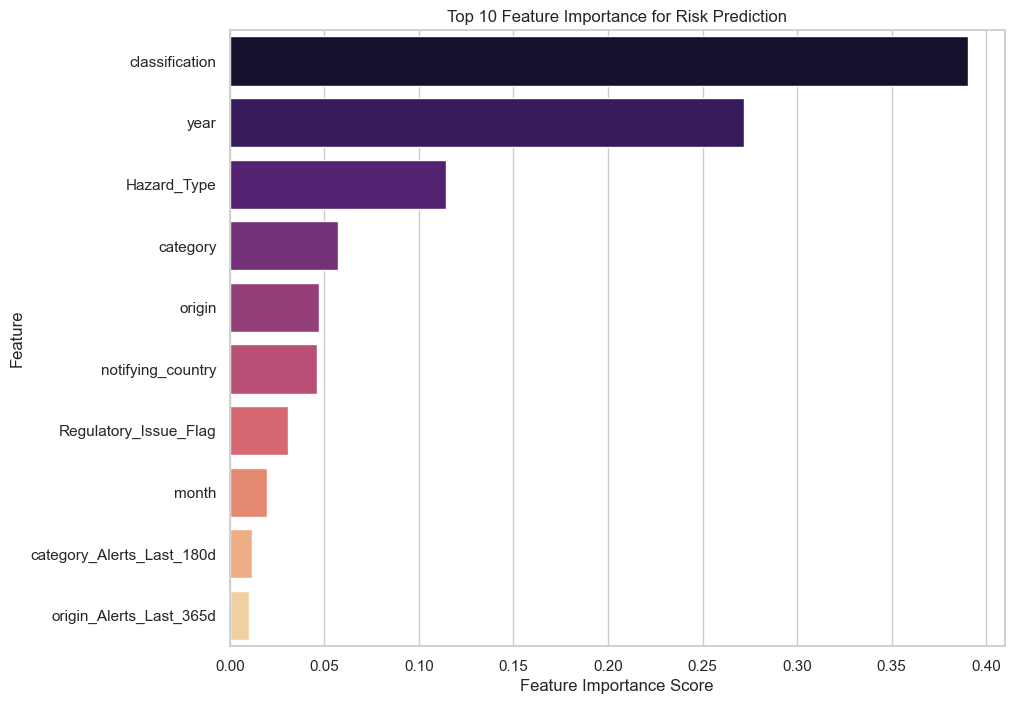

In [75]:
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# =========================================================================
# DATA PREPARATION FUNCTIONS (Required for final cleaning and encoding)
# =========================================================================

def prepare_data_for_modeling(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.Series, LabelEncoder]:
    """
    Prepares the final feature matrix (X) and target vector (y) for modeling.
    This function must be run after loading the engineered data to correctly 
    set categorical types, define the risk order, and encode the target variable.
    """
    
    # 1. Feature Selection
    FEATURE_COLS = [
        'category', 'origin', 'notifying_country', 
        'year', 'month', 'Hazard_Type', 
        'Regulatory_Issue_Flag', 'classification',
        'category_Alerts_Last_180d', 'origin_Alerts_Last_365d'
    ]
    
    # 2. Target Variable (y) Encoding
    # Define a clear risk hierarchy for ordinal encoding
    RISK_ORDER = ['no risk', 'undecided', 'potential risk', 'potentially serious', 'not serious', 'serious']
    
    # Convert 'risk_decision' to ordered categories
    df['risk_decision'] = pd.Categorical(
        df['risk_decision'], 
        categories=RISK_ORDER, 
        ordered=True
    )
    
    # Use LabelEncoder to convert the ordered categories to numerical targets (0 to 5)
    risk_encoder = LabelEncoder()
    # Apply fit_transform on the categorical labels (converted to string)
    df['risk_target'] = risk_encoder.fit_transform(df['risk_decision'].astype(str))
    y = df['risk_target']

    print(f"\nTarget Variable 'risk_decision' mapped to numerical labels (0 to {len(RISK_ORDER) - 1}):")
    for i, label in enumerate(RISK_ORDER):
        print(f"  {i}: {label}")


    # 3. Feature Engineering & Preparation
    # a. Temporal Features
    df['month'] = df['month'].astype(int)
    df['year'] = df['year'].astype(int)

    # b. Categorical Features
    categorical_cols = ['category', 'origin', 'notifying_country', 'Hazard_Type', 'classification']
    
    # Use Pandas Categorical dtype for efficient XGBoost handling
    for col in categorical_cols:
        df[col] = df[col].astype('category')
        
    # Final feature matrix X
    X = df[FEATURE_COLS]
    
    return X, y, risk_encoder

# =========================================================================
# MODELING FUNCTIONS
# =========================================================================

def get_feature_importance_df(model, feature_names):
    """Creates a clean DataFrame of feature importance scores."""
    importance = pd.Series(model.feature_importances_, index=feature_names).sort_values(ascending=False)
    return importance.reset_index().rename(columns={'index': 'Feature', 0: 'Importance'})


def train_and_evaluate_model(X: pd.DataFrame, y: pd.Series, full_df: pd.DataFrame, risk_encoder: LabelEncoder, split_date: str):
    """
    Trains an XGBoost classifier for multi-class prediction and evaluates its performance
    using a time-based split based on the date index.
    
    The split now uses boolean masks on the full DataFrame's date column to prevent 
    index misalignment errors during training.
    """
    
    # 1. Data Split: MANUAL TIME-BASED SPLIT using boolean masks
    split_date_dt = pd.to_datetime(split_date)
    
    # Create masks using the date column from the full DataFrame
    mask_train = full_df['date'] < split_date_dt
    mask_test = full_df['date'] >= split_date_dt
    
    # Apply the masks to the correctly aligned X and y DataFrames/Series
    X_train = X[mask_train]
    y_train = y[mask_train]
    
    X_test = X[mask_test]
    y_test = y[mask_test]

    total_incidents = X_train.shape[0] + X_test.shape[0]
    
    print(f"\n--- Data Split for Proactive Prediction (Cut-off: {split_date}) ---")
    print(f"Training Set (Historical): {X_train.shape[0]} incidents (~{X_train.shape[0] / total_incidents * 100:.1f}%)")
    print(f"Testing Set (Future/Holdout): {X_test.shape[0]} incidents (~{X_test.shape[0] / total_incidents * 100:.1f}%)")
    
    if X_test.empty:
        print("\nERROR: Test set is empty. Check your 'split_date' or data time range.")
        return

    # 2. XGBoost Setup
    model = xgb.XGBClassifier(
        objective='multi:softprob',  # For multi-class prediction
        num_class=len(risk_encoder.classes_),
        eval_metric='mlogloss',
        n_estimators=150,
        max_depth=5,
        learning_rate=0.1,
        random_state=42,
        tree_method='hist', # Faster training, essential for large datasets
        enable_categorical=True # Handles the category type directly from Pandas
    )
    
    # 3. Training
    model.fit(X_train, y_train)

    # 4. Prediction and Evaluation
    y_pred = model.predict(X_test)
    
    print("\n--- Model Evaluation on Future Data ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    
    # Classification Report provides metrics for each class (0 to 5)
    target_names = risk_encoder.classes_
    # FIX: Explicitly specify the labels (0 to 5) to prevent ValueError 
    # when the test set is missing one or more classes.
    labels_range = range(len(risk_encoder.classes_))
    print("\nClassification Report (Precision, Recall, F1-Score per Risk Level):")
    print(classification_report(y_test, y_pred, labels=labels_range, target_names=target_names, zero_division=0))

    # 5. Feature Importance Analysis
    importance_df = get_feature_importance_df(model, X_train.columns)
    
    print("\n--- Top 10 Feature Importance ---")
    print(importance_df.head(10).to_markdown(index=False))

    # 6. Visualization (Feature Importance Plot)
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette="magma")
    plt.title('Top 10 Feature Importance for Risk Prediction')
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Feature')
    plt.show()

# =========================================================================
# MAIN EXECUTION LOGIC (Starts here)
# =========================================================================

# STEP 0: LOAD YOUR PREPARED DATA
try:
    # NOTE: Replace 'rasff_flag_lagged.csv' if your saved file has a different name
    prepared_df = pd.read_csv(r'F:\Final_project\rasff_new3.csv') 
    
    # Ensure the 'date' column is loaded correctly for splitting
    # This column must be a unique column that is NOT used as the main index
    prepared_df['date'] = pd.to_datetime(prepared_df['date'])
    
    # Ensure the DataFrame is sorted by date before splitting
    prepared_df.sort_values('date', inplace=True)
    
except FileNotFoundError:
    prepared_df = pd.DataFrame() 
    print("ERROR: Please ensure 'rasff_flag_lagged.csv' is saved and accessible, or update the file path.")

if prepared_df.empty:
    print("Model training skipped due to empty DataFrame.")
else:
    print("--- Starting XGBoost Modeling Workflow ---")
    
    # A. Final Data Preparation and Encoding
    # X and y now share the standard, unique integer index (0, 1, 2, ...)
    X, y, risk_encoder = prepare_data_for_modeling(prepared_df.copy())
    
    # B. Calculate the dynamic 80/20 split date based on incident count
    # We use the index of the full, sorted DataFrame to determine the split boundary date.
    rows_total = len(prepared_df)
    split_index = int(rows_total * 0.8)
    
    if split_index >= rows_total:
         split_index = rows_total - 1
    
    # Get the date of the incident at the 80% mark.
    # We use .iloc to access the position in the sorted DataFrame
    TIME_SPLIT_DATE = prepared_df.iloc[split_index]['date'].strftime('%Y-%m-%d')
    print(f"Calculated 80% split point (by incident count) is: {TIME_SPLIT_DATE}")
    
    # C. Train and Evaluate using the time-based split
    # We pass the full prepared_df to train_and_evaluate_model to use its 'date' column 
    # to create the boolean masks for splitting X and y.
    train_and_evaluate_model(X, y, prepared_df, risk_encoder, TIME_SPLIT_DATE)

In [76]:
rasff_flag_lagged.head()

reference                                     category  \
0  2020.0001                        fruits and vegetables   
1  2020.0004                        fruits and vegetables   
2  2020.0007                        fruits and vegetables   
3  2020.0008  meat and meat products (other than poultry)   
4  2020.0010                       food contact materials   

                    type                                            subject  \
0                   food              Aflatoxins in dried figs from Turkey    
1                   food               aflatoxins in dried figs from Turkey   
2                   food           fosthiazate in fresh peppers from Turkey   
3                   food  Salmonella spp. (in 1 out of 5 samples) in Hot...   
4  food contact material  migration of formaldehyde form bamboo mug from...   

                 date notifying_country                 classification  \
0 2020-01-02 09:24:48            France  border rejection notification   
1 2020-01-02 11:06:54             Italy  border rejection notification   
2 2020-01-02 12:35:16          Bulgaria  border rejection notification   
3 2020-01-02 12:35:36            Poland             alert notification   
4 2020-01-02 13:42:42            Poland             alert notification   

  risk_decision                       distribution forAttention  \
0       serious                                NaN          NaN   
1       serious                                NaN          NaN   
2       serious                                NaN          NaN   
3       serious                            Estonia       Poland   
4       serious  Belarus,Lithuania,Poland,Slovakia          NaN   

          forFollowUp         operator   origin                   hazards  \
0                 NaN          Türkiye  Türkiye            Aflatoxins B1    
1                 NaN    Italy,Türkiye  Türkiye          aflatoxin total    
2                 NaN  Germany,Türkiye  Türkiye             fosthiazate     
3                 NaN   Estonia,Poland   Poland  Salmonella  enteritidis    
4  Lithuania,Slovakia     China,Poland    China   formaldehyde  migration   

   year  month               Hazard_Type  Regulatory_Issue_Flag  \
0  2020      1                Mycotoxins                      0   
1  2020      1                Mycotoxins                      0   
2  2020      1     Chemical/Contaminants                      0   
3  2020      1           Microbiological                      0   
4  2020      1  Migration from Packaging                      0   

   category_Alerts_Last_180d  origin_Alerts_Last_365d  
0                          0                        0  
1                          1                        1  
2                          2                        2  
3                          0                        0  
4                          0                        0

--- Starting XGBoost Modeling Workflow ---

Target Variable 'risk_decision' mapped to numerical labels (0 to 5):
  0: no risk
  1: undecided
  2: potential risk
  3: potentially serious
  4: not serious
  5: serious
Calculated 80% split point (by incident count) is: 2024-10-22

--- Data Split for Proactive Prediction (Cut-off: 2024-10-22) ---
Training Set (Historical): 21435 incidents (~79.9%)
Testing Set (Future/Holdout): 5388 incidents (~20.1%)

--- Model Evaluation on Future Data ---
Accuracy: 0.5676

Classification Report (Precision, Recall, F1-Score per Risk Level):
                     precision    recall  f1-score   support

            no risk       0.14      0.11      0.12        63
        not serious       0.50      0.42      0.46       724
     potential risk       0.50      0.37      0.42      1049
potentially serious       0.38      0.18      0.24      1031
            serious       0.63      0.86      0.73      2521
          undecided       0.00      0.00      0.00     

C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_27368\3060785177.py:147: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette="magma")


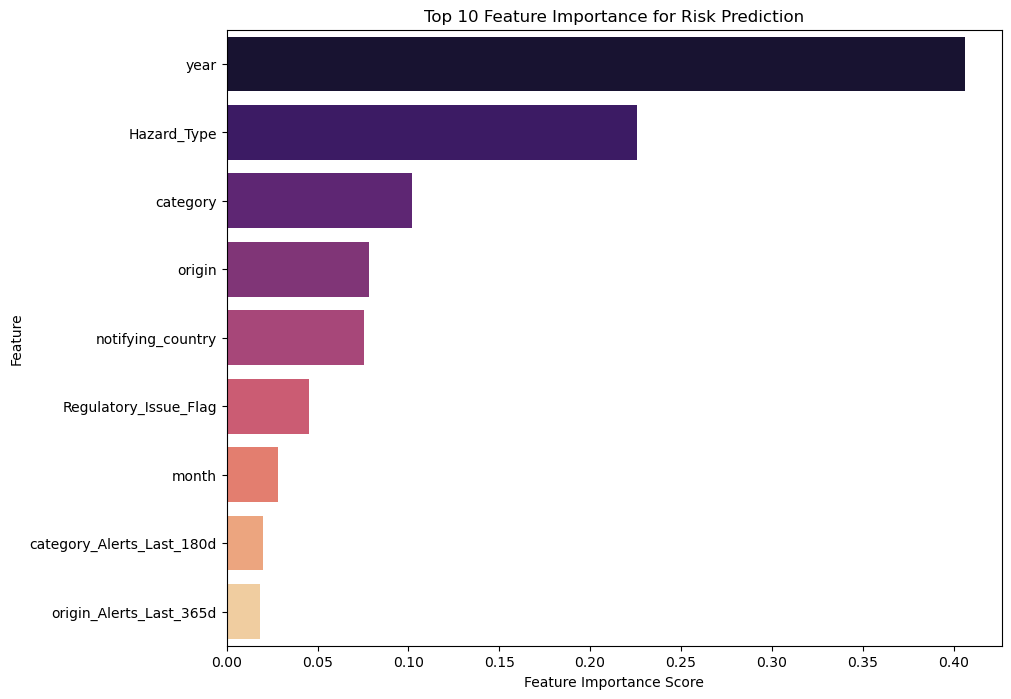

In [4]:
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# =========================================================================
# DATA PREPARATION FUNCTIONS (Required for final cleaning and encoding)
# =========================================================================

def prepare_data_for_modeling(df: pd.DataFrame) -> tuple[pd.DataFrame, pd.Series, LabelEncoder]:
    """
    Prepares the final feature matrix (X) and target vector (y) for modeling.
    This function must be run after loading the engineered data to correctly 
    set categorical types, define the risk order, and encode the target variable.
    """
    
    # 1. Feature Selection
    FEATURE_COLS = [
        'category', 'origin', 'notifying_country', 
        'year', 'month', 'Hazard_Type', 
        'Regulatory_Issue_Flag', 
        'category_Alerts_Last_180d', 'origin_Alerts_Last_365d'
    ]
    
    # 2. Target Variable (y) Encoding
    # Define a clear risk hierarchy for ordinal encoding
    RISK_ORDER = ['no risk', 'undecided', 'potential risk', 'potentially serious', 'not serious', 'serious']
    
    # Convert 'risk_decision' to ordered categories
    df['risk_decision'] = pd.Categorical(
        df['risk_decision'], 
        categories=RISK_ORDER, 
        ordered=True
    )
    
    # Use LabelEncoder to convert the ordered categories to numerical targets (0 to 5)
    risk_encoder = LabelEncoder()
    # Apply fit_transform on the categorical labels (converted to string)
    df['risk_target'] = risk_encoder.fit_transform(df['risk_decision'].astype(str))
    y = df['risk_target']

    print(f"\nTarget Variable 'risk_decision' mapped to numerical labels (0 to {len(RISK_ORDER) - 1}):")
    for i, label in enumerate(RISK_ORDER):
        print(f"  {i}: {label}")


    # 3. Feature Engineering & Preparation
    # a. Temporal Features
    df['month'] = df['month'].astype(int)
    df['year'] = df['year'].astype(int)

    # b. Categorical Features
    categorical_cols = ['category', 'origin', 'notifying_country', 'Hazard_Type', 'classification']
    
    # Use Pandas Categorical dtype for efficient XGBoost handling
    for col in categorical_cols:
        df[col] = df[col].astype('category')
        
    # Final feature matrix X
    X = df[FEATURE_COLS]
    
    return X, y, risk_encoder

# =========================================================================
# MODELING FUNCTIONS
# =========================================================================

def get_feature_importance_df(model, feature_names):
    """Creates a clean DataFrame of feature importance scores."""
    importance = pd.Series(model.feature_importances_, index=feature_names).sort_values(ascending=False)
    return importance.reset_index().rename(columns={'index': 'Feature', 0: 'Importance'})


def train_and_evaluate_model(X: pd.DataFrame, y: pd.Series, full_df: pd.DataFrame, risk_encoder: LabelEncoder, split_date: str):
    """
    Trains an XGBoost classifier for multi-class prediction and evaluates its performance
    using a time-based split based on the date index.
    
    The split now uses boolean masks on the full DataFrame's date column to prevent 
    index misalignment errors during training.
    """
    
    # 1. Data Split: MANUAL TIME-BASED SPLIT using boolean masks
    split_date_dt = pd.to_datetime(split_date)
    
    # Create masks using the date column from the full DataFrame
    mask_train = full_df['date'] < split_date_dt
    mask_test = full_df['date'] >= split_date_dt
    
    # Apply the masks to the correctly aligned X and y DataFrames/Series
    X_train = X[mask_train]
    y_train = y[mask_train]
    
    X_test = X[mask_test]
    y_test = y[mask_test]

    total_incidents = X_train.shape[0] + X_test.shape[0]
    
    print(f"\n--- Data Split for Proactive Prediction (Cut-off: {split_date}) ---")
    print(f"Training Set (Historical): {X_train.shape[0]} incidents (~{X_train.shape[0] / total_incidents * 100:.1f}%)")
    print(f"Testing Set (Future/Holdout): {X_test.shape[0]} incidents (~{X_test.shape[0] / total_incidents * 100:.1f}%)")
    
    if X_test.empty:
        print("\nERROR: Test set is empty. Check your 'split_date' or data time range.")
        return

    # 2. XGBoost Setup
    model = xgb.XGBClassifier(
        objective='multi:softprob',  # For multi-class prediction
        num_class=len(risk_encoder.classes_),
        eval_metric='mlogloss',
        n_estimators=150,
        max_depth=5,
        learning_rate=0.1,
        random_state=42,
        tree_method='hist', # Faster training, essential for large datasets
        enable_categorical=True # Handles the category type directly from Pandas
    )
    
    # 3. Training
    model.fit(X_train, y_train)

    # 4. Prediction and Evaluation
    y_pred = model.predict(X_test)
    
    print("\n--- Model Evaluation on Future Data ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    
    # Classification Report provides metrics for each class (0 to 5)
    target_names = risk_encoder.classes_
    # FIX: Explicitly specify the labels (0 to 5) to prevent ValueError 
    # when the test set is missing one or more classes.
    labels_range = range(len(risk_encoder.classes_))
    print("\nClassification Report (Precision, Recall, F1-Score per Risk Level):")
    print(classification_report(y_test, y_pred, labels=labels_range, target_names=target_names, zero_division=0))

    # 5. Feature Importance Analysis
    importance_df = get_feature_importance_df(model, X_train.columns)
    
    print("\n--- Top 10 Feature Importance ---")
    print(importance_df.head(10).to_markdown(index=False))

    # 6. Visualization (Feature Importance Plot)
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(10), palette="magma")
    plt.title('Top 10 Feature Importance for Risk Prediction')
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Feature')
    plt.show()

# =========================================================================
# MAIN EXECUTION LOGIC (Starts here)
# =========================================================================

# STEP 0: LOAD YOUR PREPARED DATA
try:
    # NOTE: Replace 'rasff_flag_lagged.csv' if your saved file has a different name
    prepared_df = pd.read_csv(r'F:\Final_project\rasff_new3.csv') 
    
    # Ensure the 'date' column is loaded correctly for splitting
    # This column must be a unique column that is NOT used as the main index
    prepared_df['date'] = pd.to_datetime(prepared_df['date'])
    
    # Ensure the DataFrame is sorted by date before splitting
    prepared_df.sort_values('date', inplace=True)
    
except FileNotFoundError:
    prepared_df = pd.DataFrame() 
    print("ERROR: Please ensure 'rasff_flag_lagged.csv' is saved and accessible, or update the file path.")

if prepared_df.empty:
    print("Model training skipped due to empty DataFrame.")
else:
    print("--- Starting XGBoost Modeling Workflow ---")
    
    # A. Final Data Preparation and Encoding
    # X and y now share the standard, unique integer index (0, 1, 2, ...)
    X, y, risk_encoder = prepare_data_for_modeling(prepared_df.copy())
    
    # B. Calculate the dynamic 80/20 split date based on incident count
    # We use the index of the full, sorted DataFrame to determine the split boundary date.
    rows_total = len(prepared_df)
    split_index = int(rows_total * 0.8)
    
    if split_index >= rows_total:
         split_index = rows_total - 1
    
    # Get the date of the incident at the 80% mark.
    # We use .iloc to access the position in the sorted DataFrame
    TIME_SPLIT_DATE = prepared_df.iloc[split_index]['date'].strftime('%Y-%m-%d')
    print(f"Calculated 80% split point (by incident count) is: {TIME_SPLIT_DATE}")
    
    # C. Train and Evaluate using the time-based split
    # We pass the full prepared_df to train_and_evaluate_model to use its 'date' column 
    # to create the boolean masks for splitting X and y.
    train_and_evaluate_model(X, y, prepared_df, risk_encoder, TIME_SPLIT_DATE)